In [9]:
# Install Python packages
!pip install numpy pandas pillow torch torchvision matplotlib seaborn scikit-learn transformers nltk rouge-score

# Download NLTK punkt tokenizer
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Train Loss: 0.8398
Epoch 2/5 - Train Loss: 0.3084
Epoch 3/5 - Train Loss: 0.1727
Epoch 4/5 - Train Loss: 0.1878
Epoch 5/5 - Train Loss: 0.0816

Testing Metrics:
Accuracy (%)         : 96.67
Precision (%)        : 96.15
Recall (%)           : 100.0
F1-score (%)         : 98.04
AUC                  : 1.0
Error Rate           : 0.0333


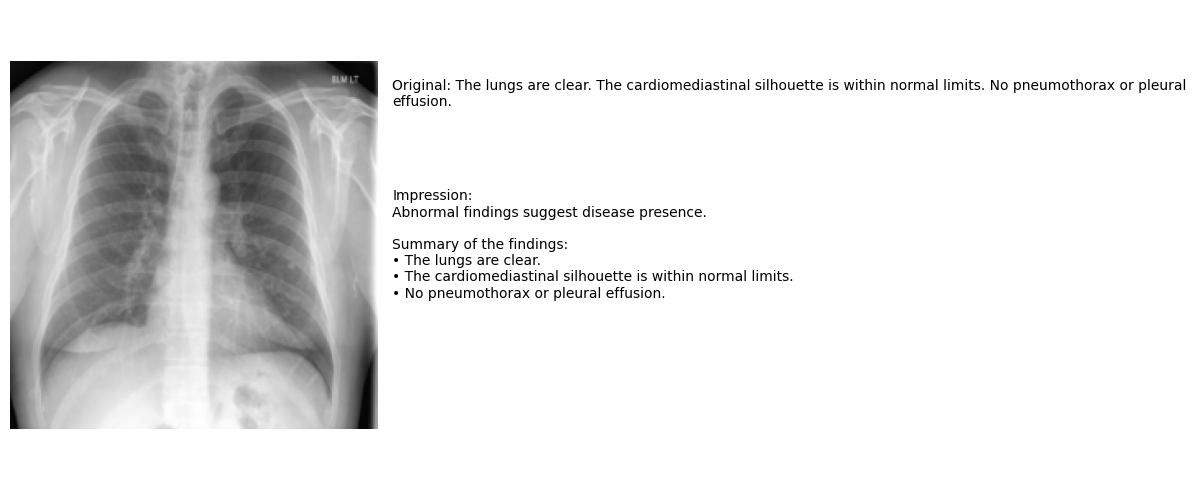

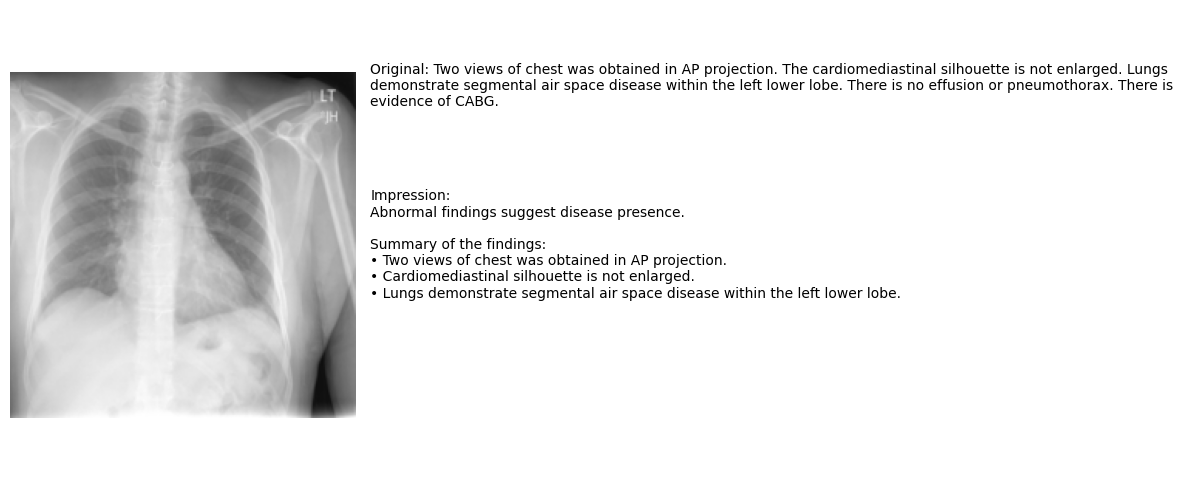

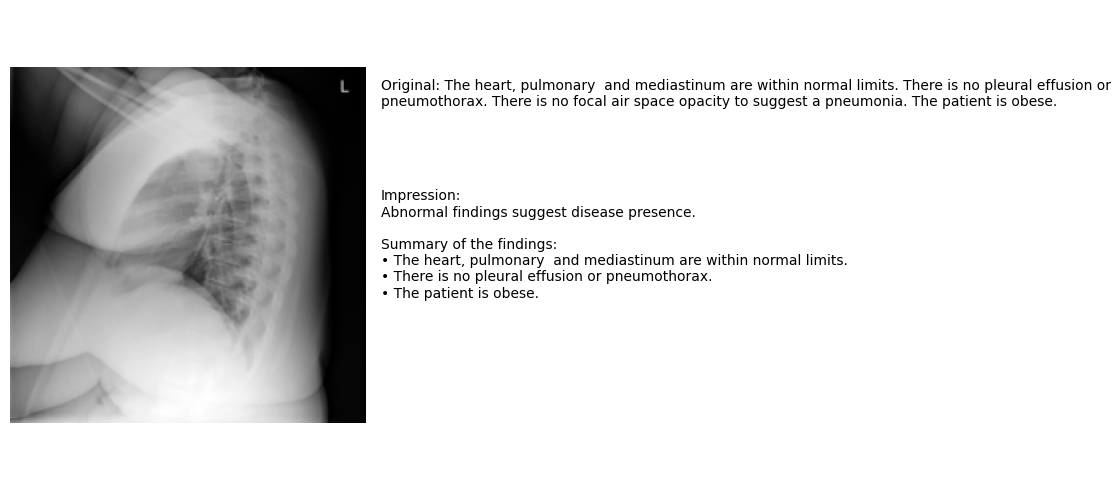

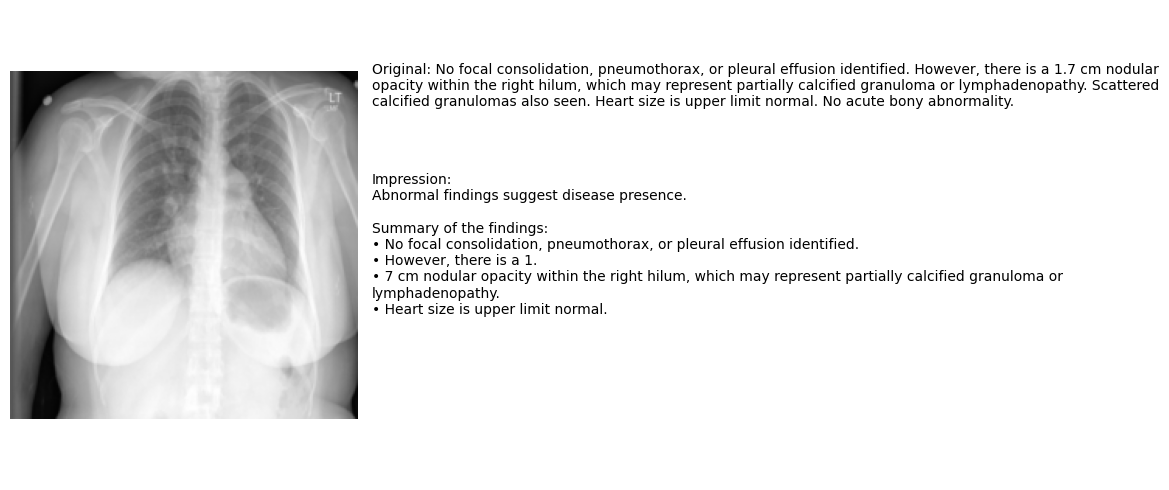

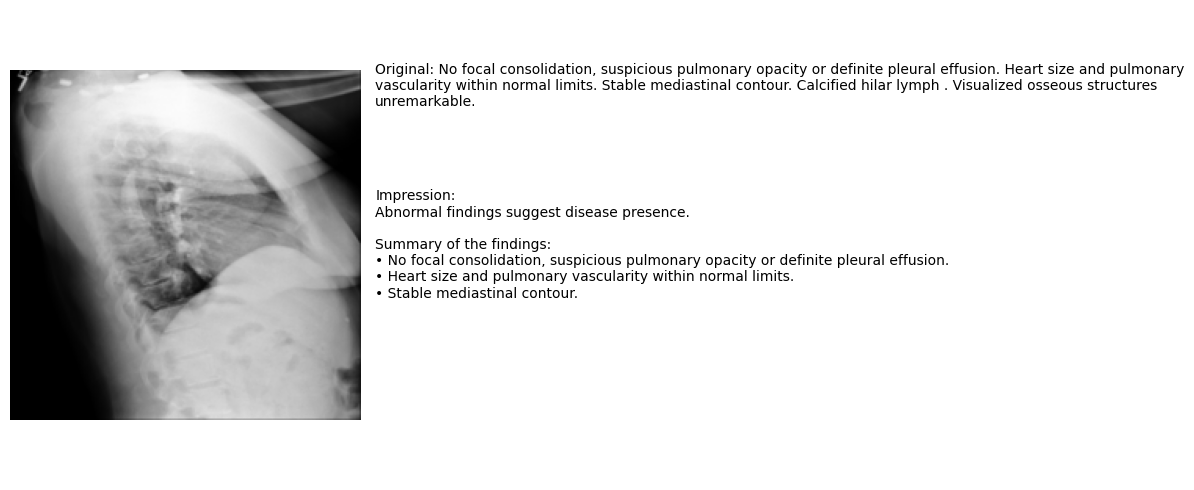

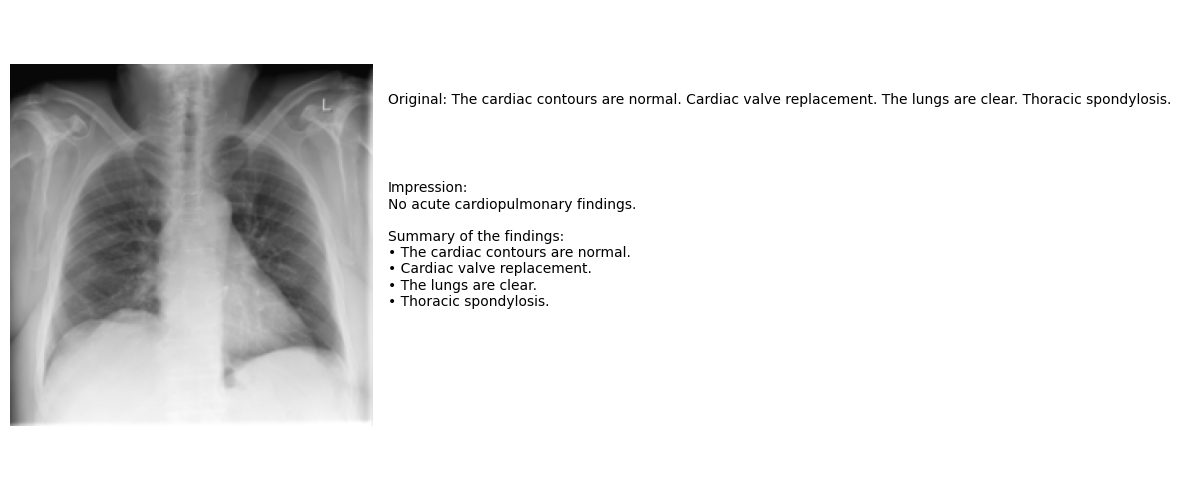

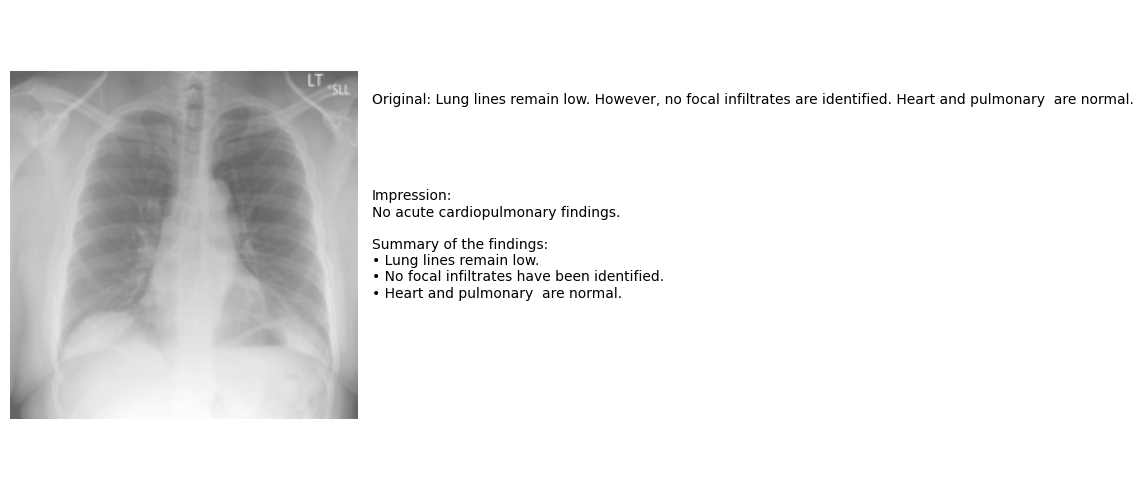

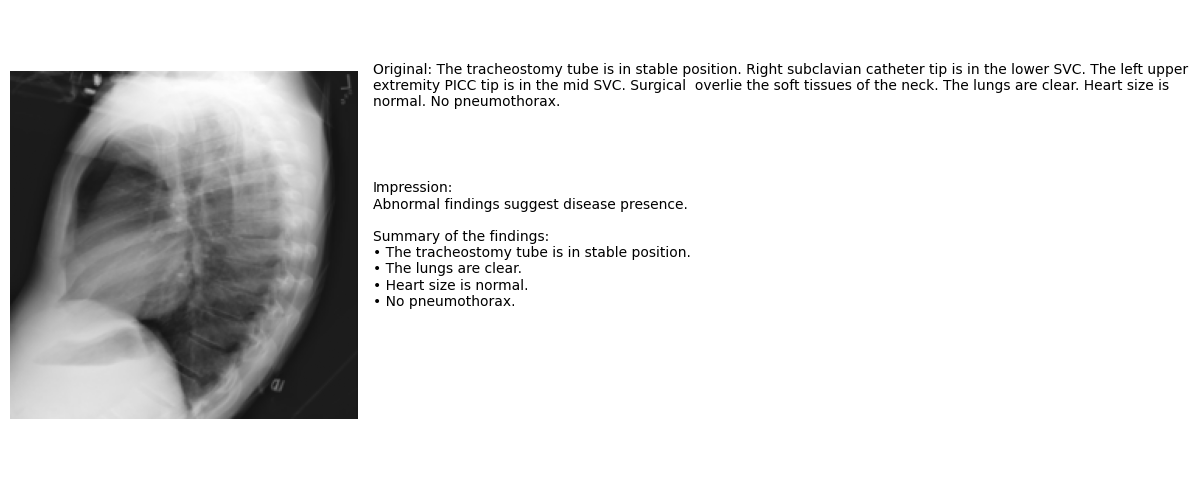

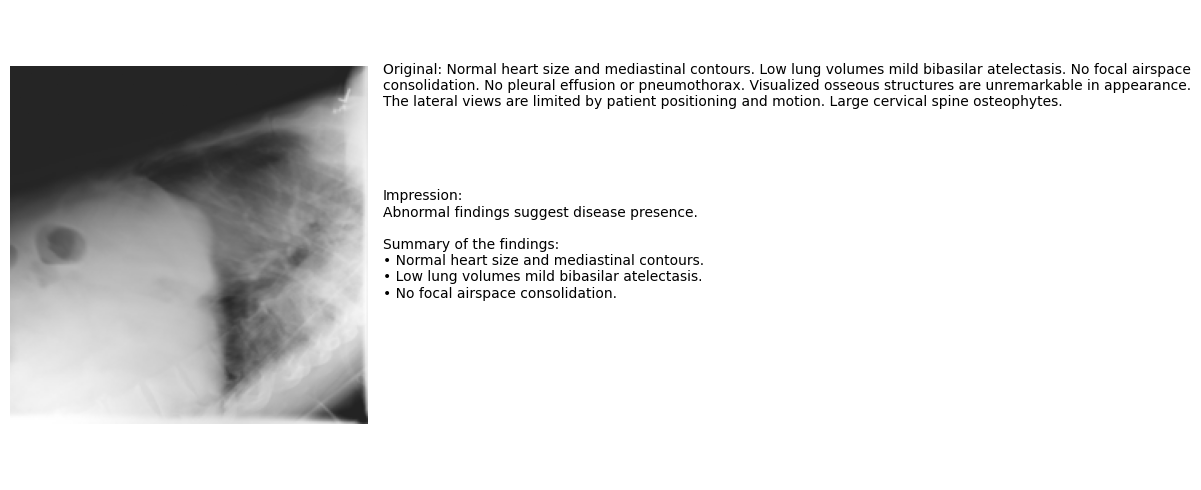

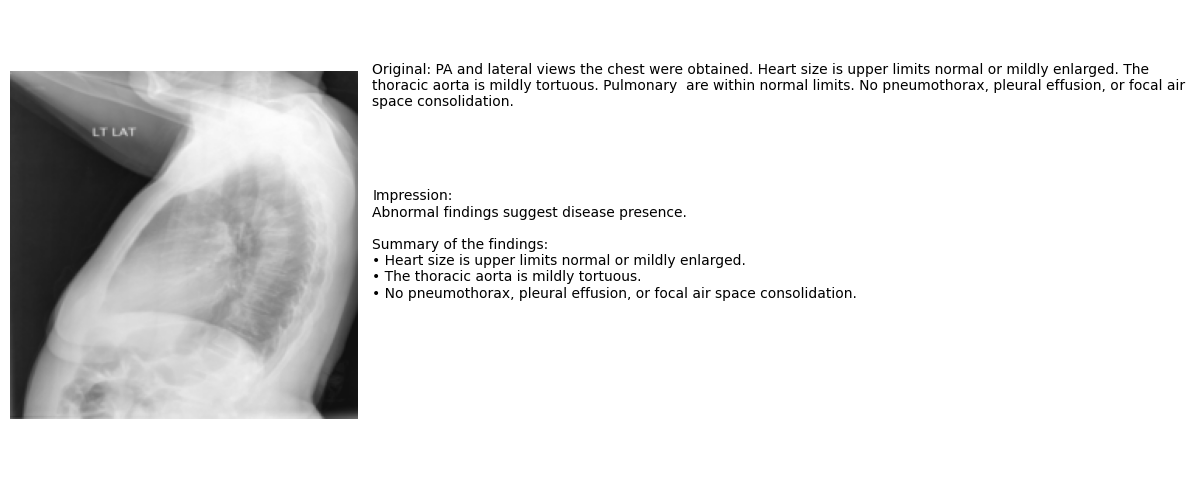

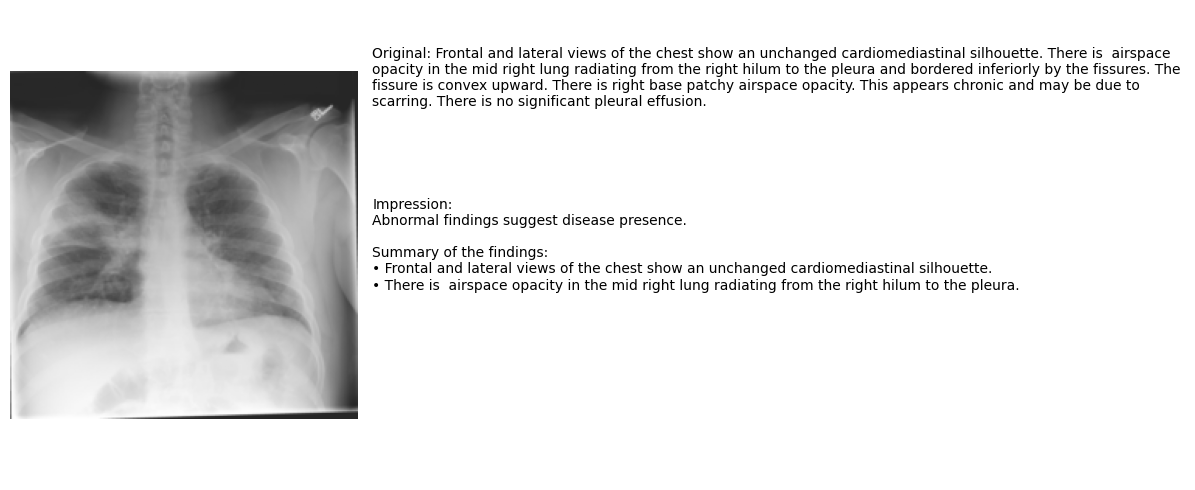

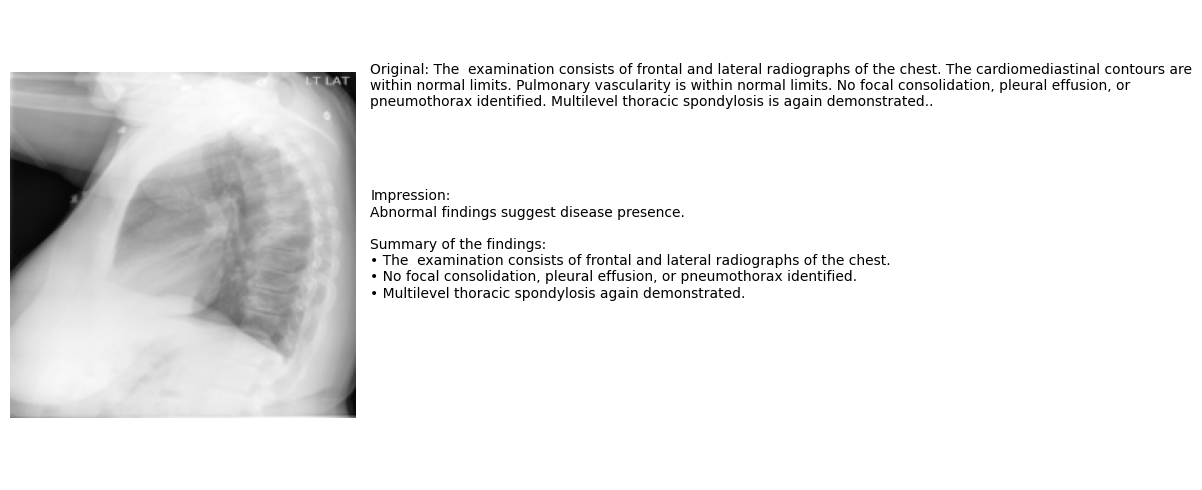

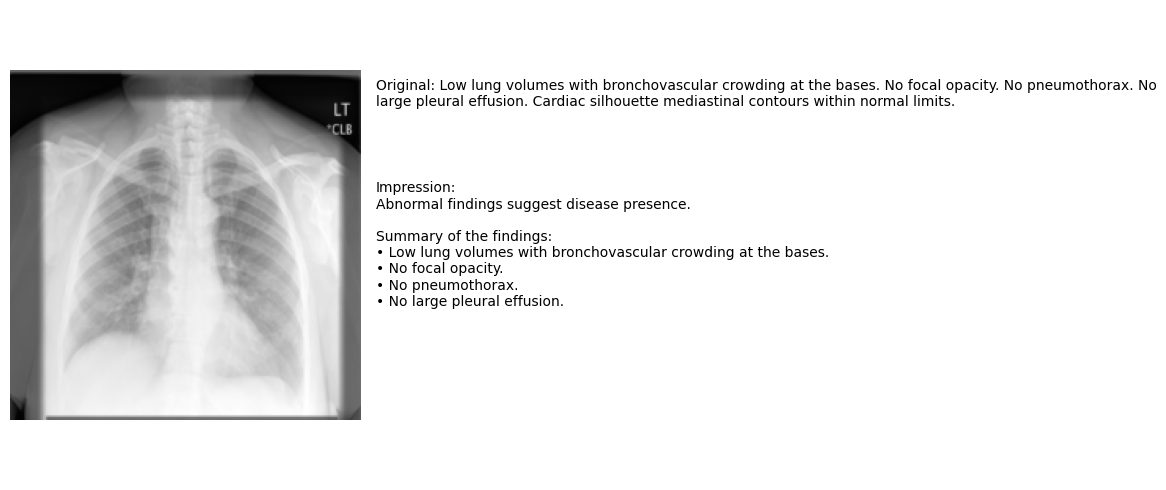

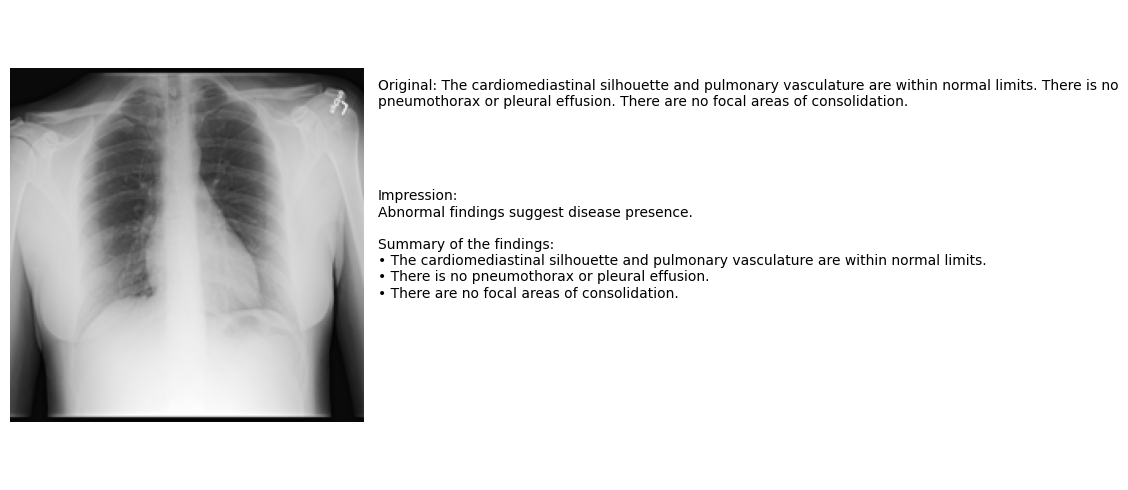

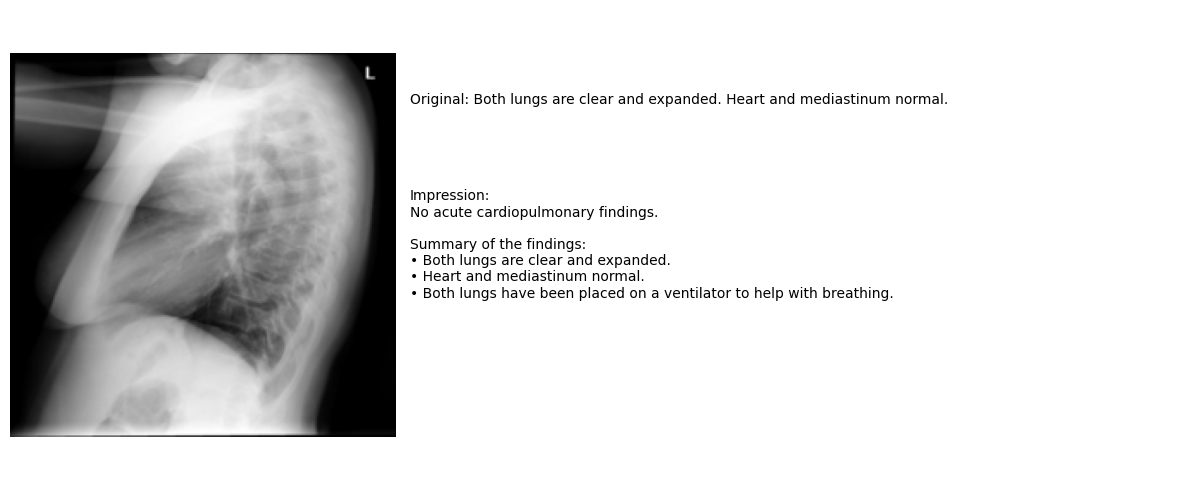

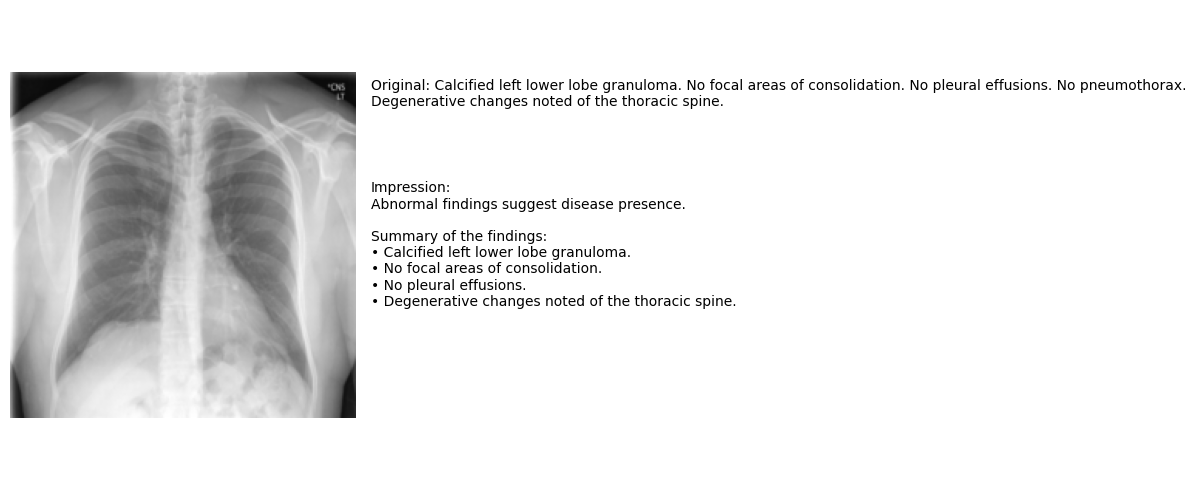

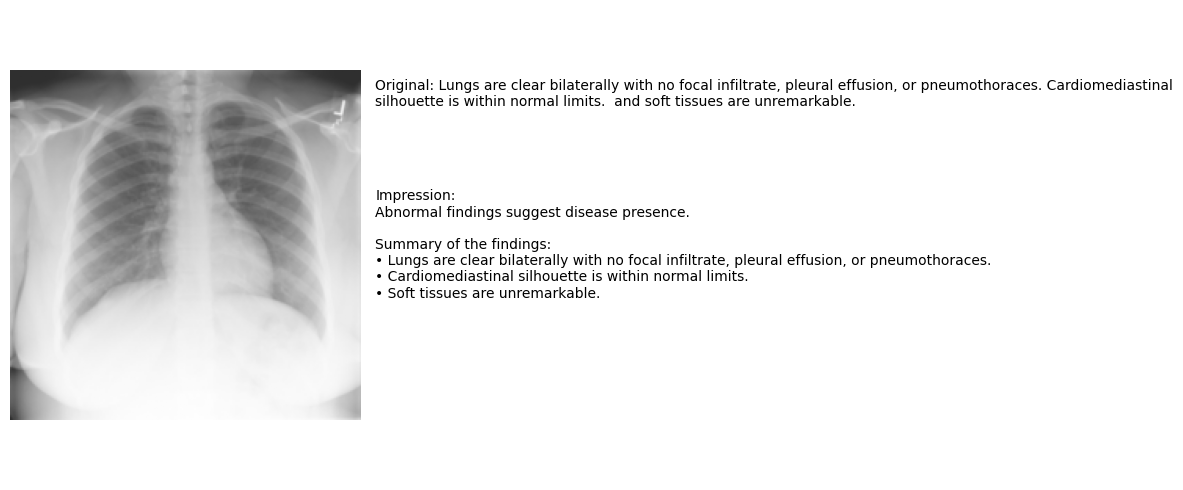

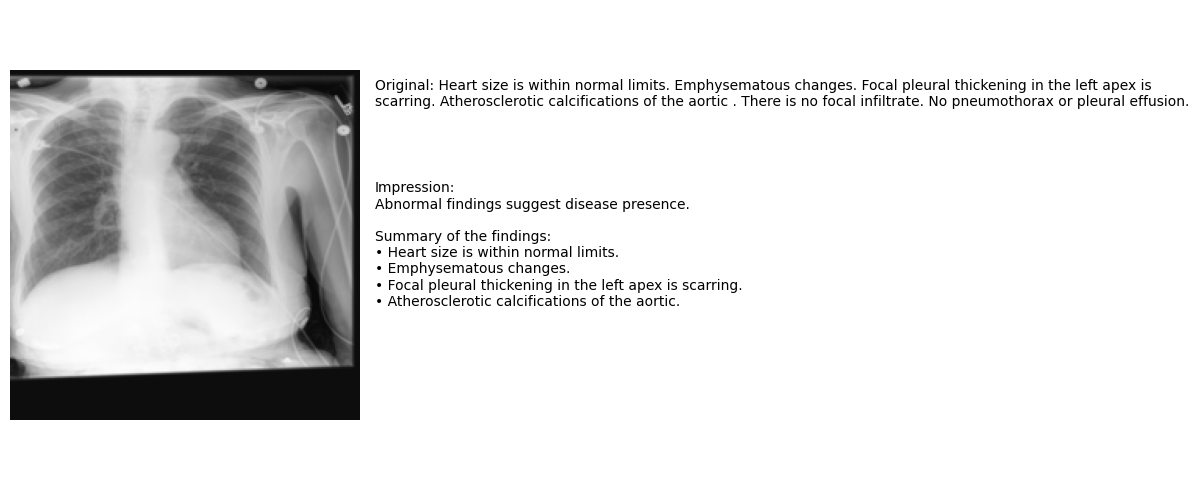

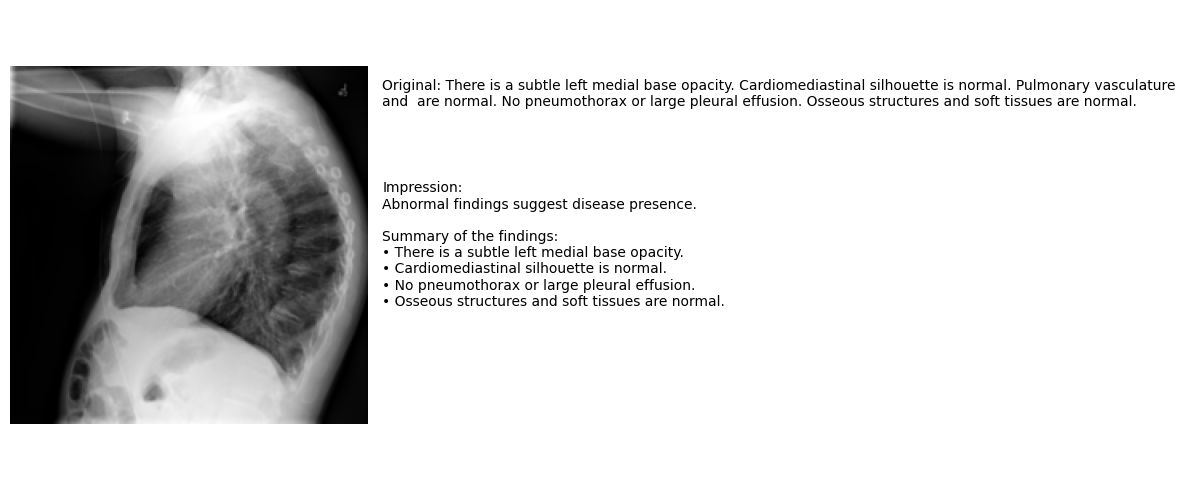

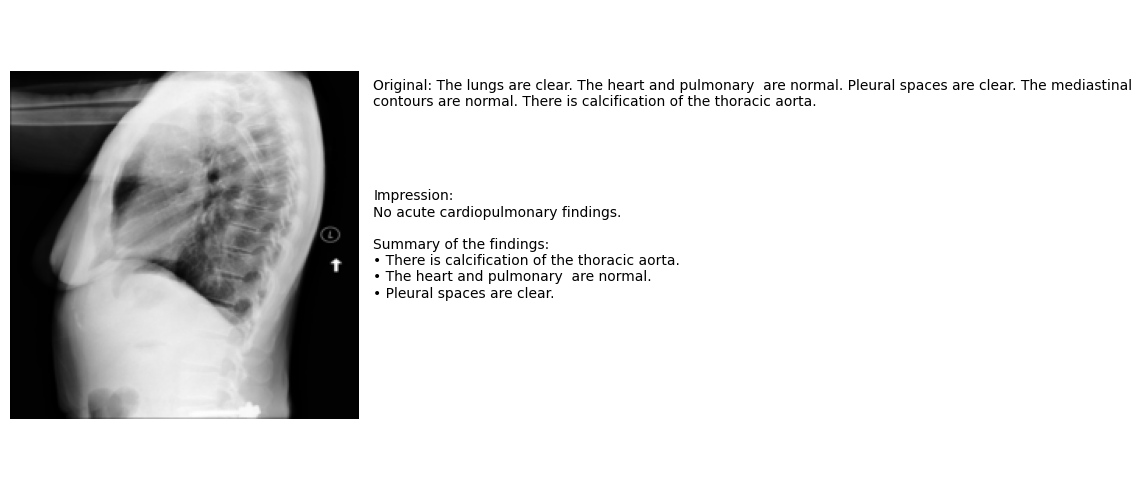

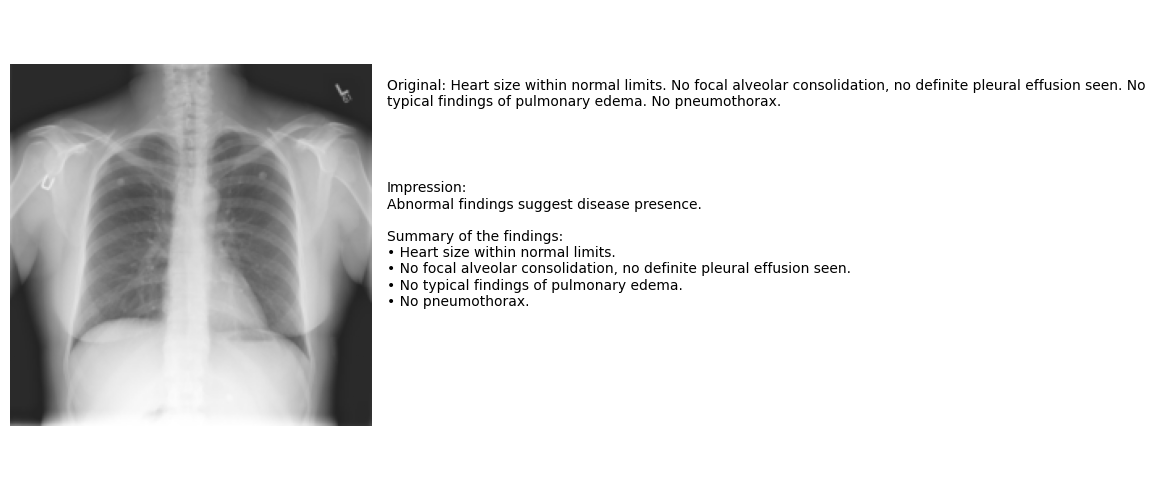

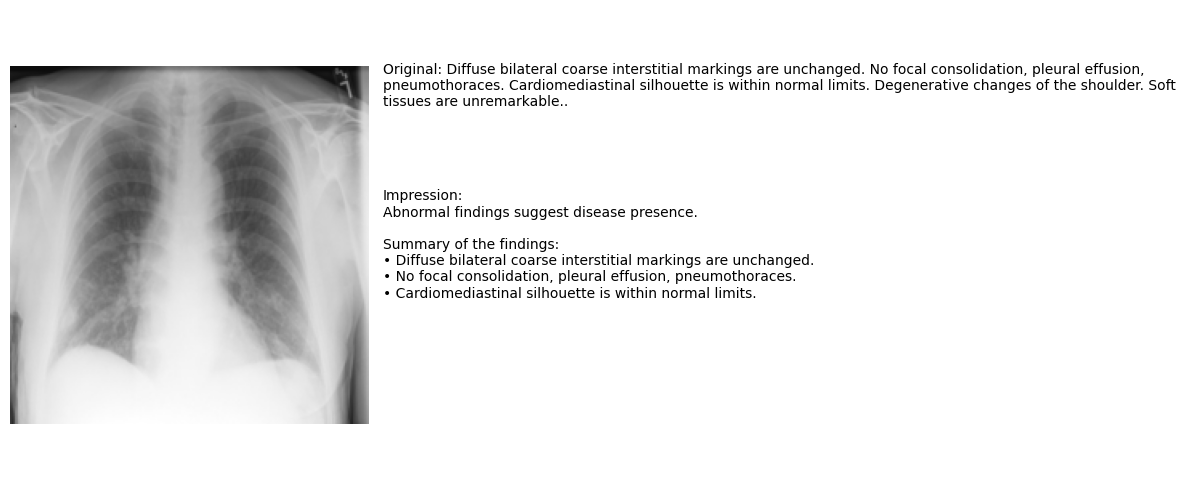

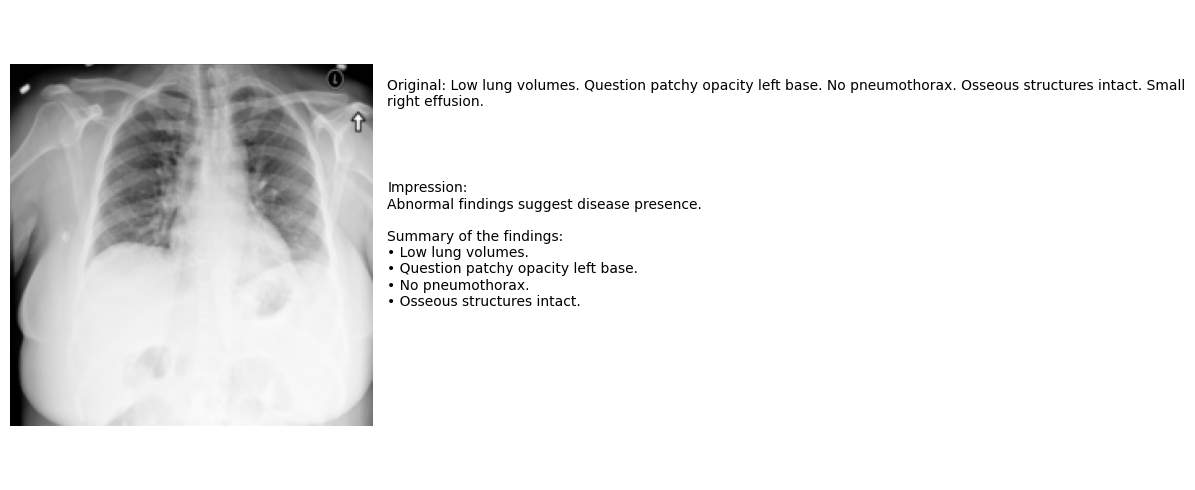

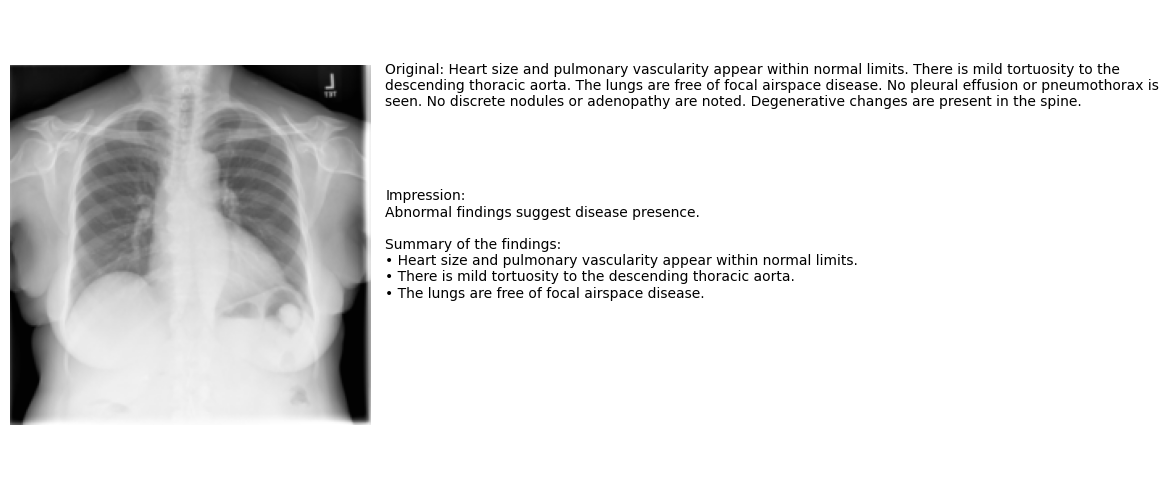

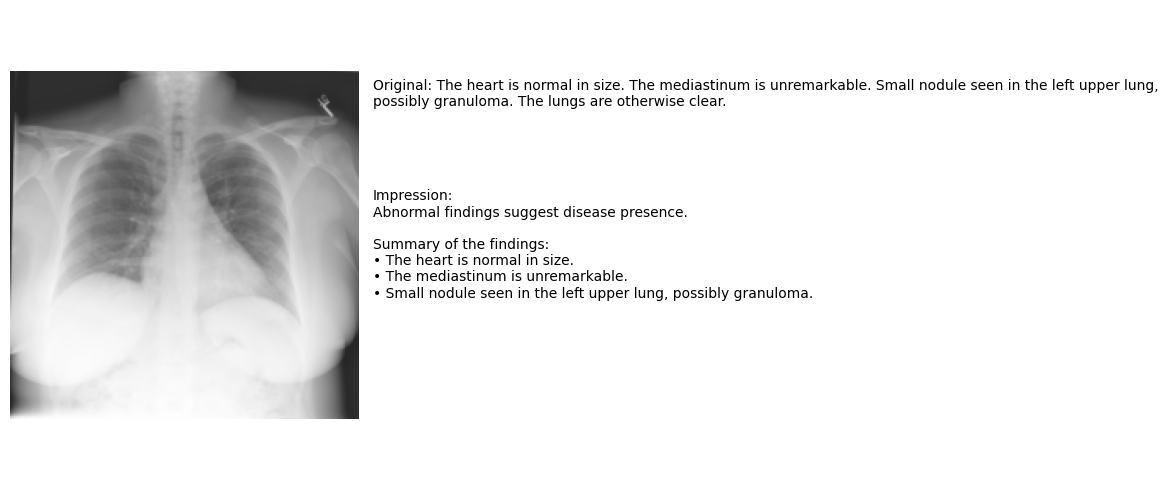

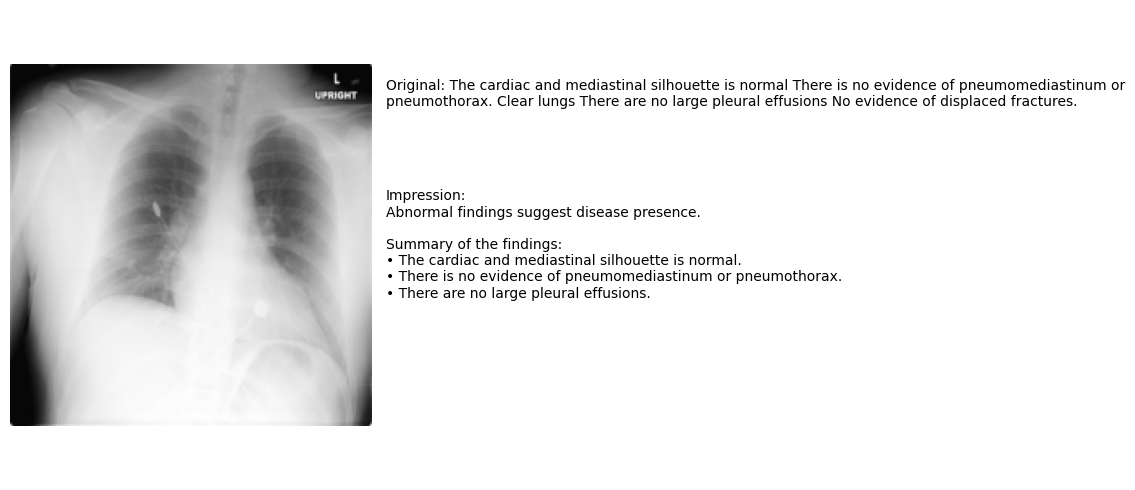

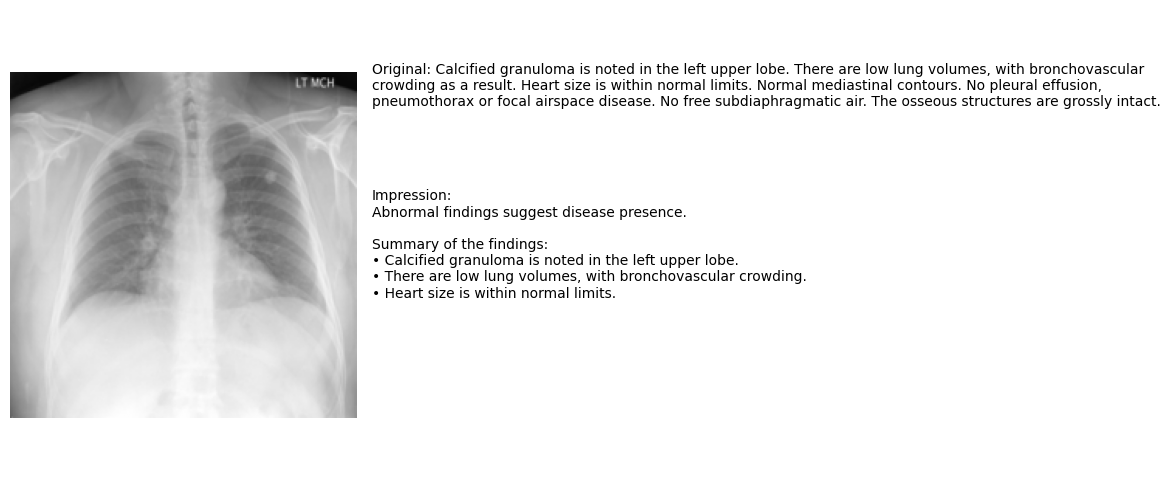

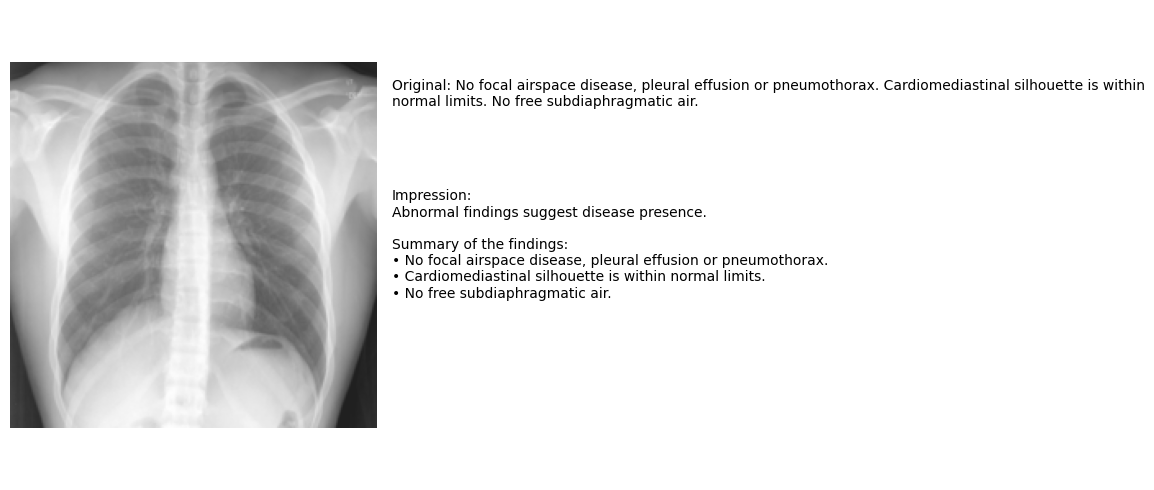

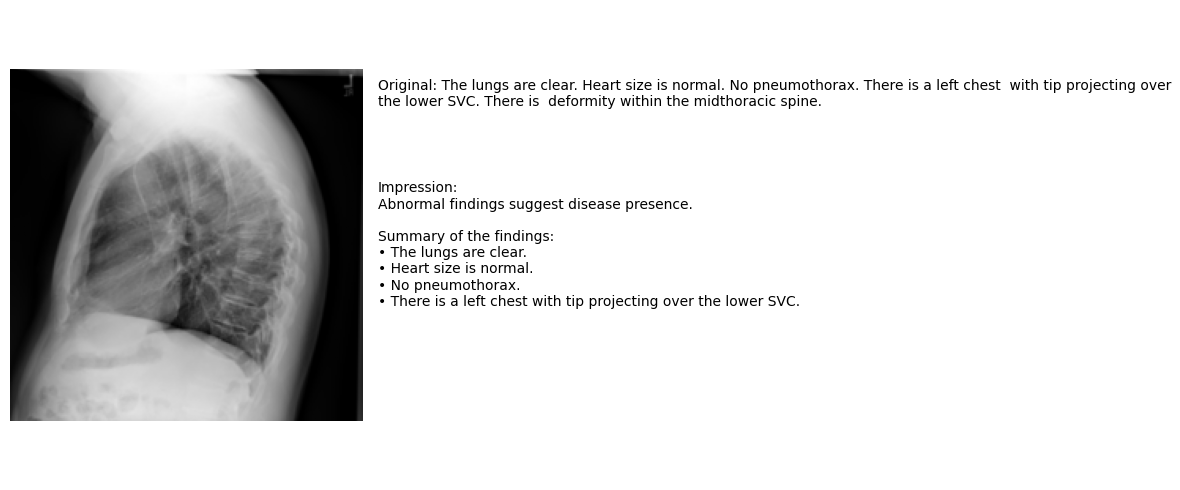

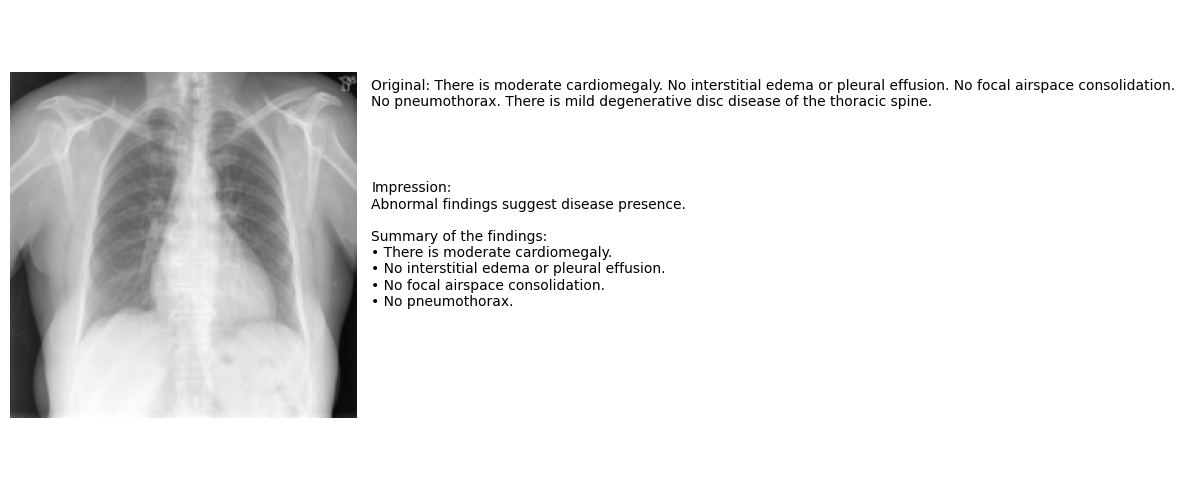

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


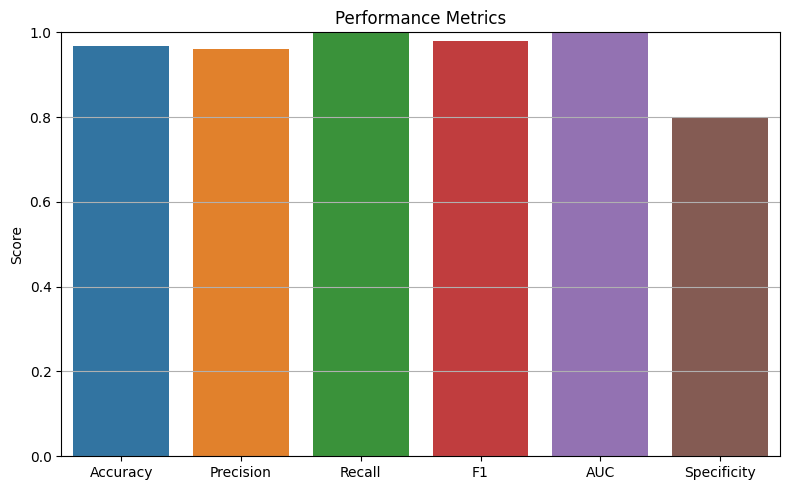

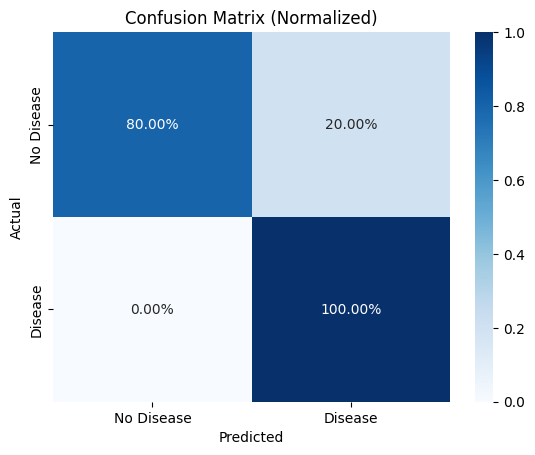

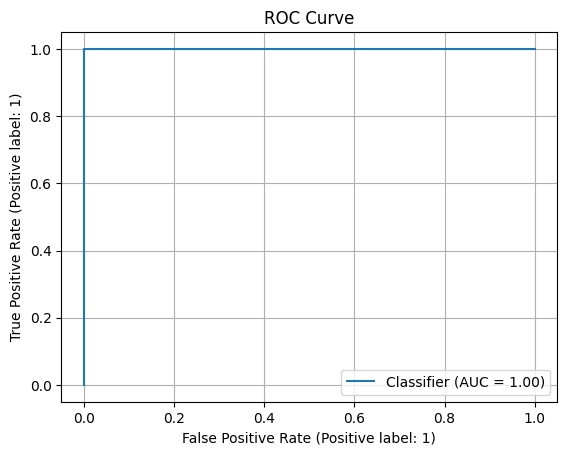


Language Metrics:
BLEU-1: 70.18
BLEU-2: 69.20
BLEU-3: 68.09
BLEU-4: 66.94
ROUGE-1: 84.52
ROUGE-2: 81.94
ROUGE-L: 83.59


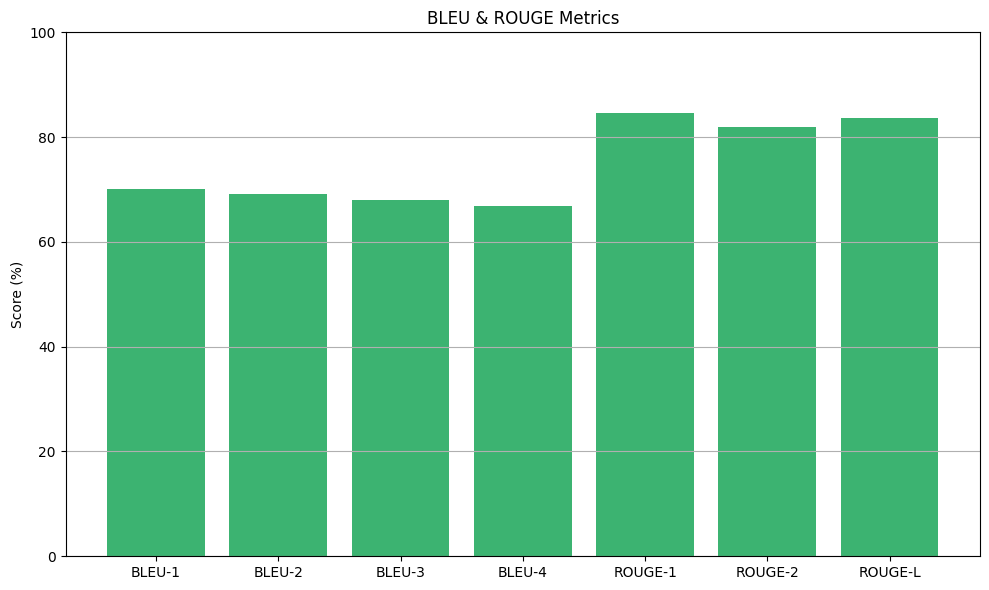

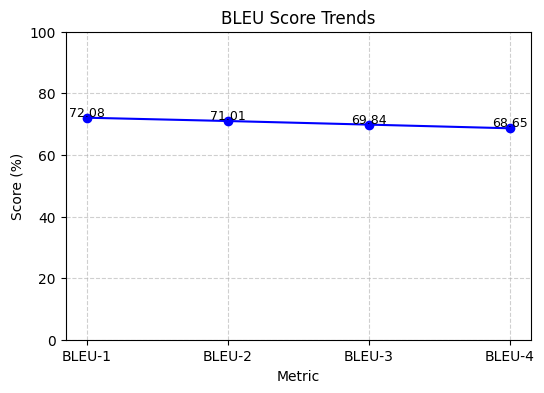

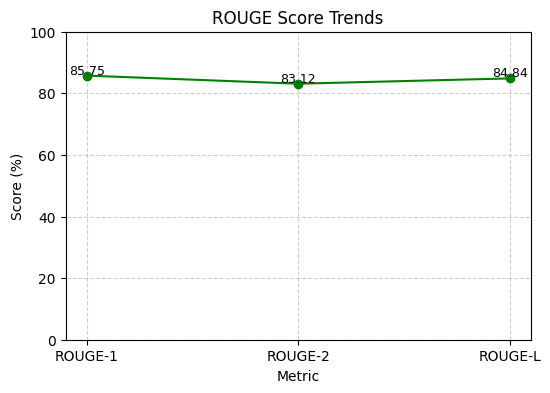

In [11]:
#!/usr/bin/env python
# coding: utf-8

# In[13]:


#!/usr/bin/env python
# coding: utf-8

import os
import re
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

from transformers import BertTokenizer, BertModel, BartTokenizer, BartForConditionalGeneration

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')

# ---------------- Dataset ---------------- #
class MedicalDataset(Dataset):
    def __init__(self, df, image_folder, tokenizer, transform):
        self.df = df
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row['filename'])
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)

        text = re.sub(r'X{2,}', '', row['findings'])
        label = 1 if any(word in text.lower() for word in ['effusion', 'opacity', 'cardiomegaly', 'edema', 'pneumothorax']) else 0

        encoded_text = self.tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
        return image_tensor, encoded_text, text, image_path, label

# ---------------- Model ---------------- #
class MultimodalSummarizer(nn.Module):
    def __init__(self):
        super(MultimodalSummarizer, self).__init__()
        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")
        self.image_encoder = nn.Sequential(
            *list(torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).children())[:-1]
        )
        self.fusion = nn.Linear(512 + 768, 2)

    def forward(self, image, input_ids, attention_mask):
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        image_features = self.image_encoder(image).squeeze()
        if len(image_features.shape) == 1:
            image_features = image_features.unsqueeze(0)
        combined = torch.cat((text_features, image_features), dim=1)
        fused = self.fusion(combined)
        return fused

# ---------------- Summary Display (robust to images=None) ---------------- #
def show_summary_table(images, texts, summaries, paths, predictions):
    texts = texts or []
    summaries = summaries or []
    paths = paths or []
    predictions = predictions or []

    # Determine how many rows to render based on provided lists
    n = max(len(texts), len(summaries), len(paths), len(predictions))
    # If images is None, create placeholders
    if images is None:
        images = [None] * n

    for i in range(n):
        fig = plt.figure(figsize=(12, 5))
        spec = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

        # Left panel - image (if we have it or can open from path)
        ax0 = plt.subplot(spec[0])
        ax0.axis("off")

        img_shown = False
        if i < len(images) and images[i] is not None:
            # If it's a torch tensor (CxHxW), convert to HxWxC
            if isinstance(images[i], torch.Tensor):
                img = images[i].detach().cpu()
                if img.ndim == 3 and img.shape[0] in (1, 3):
                    img = img.permute(1, 2, 0).numpy()
                ax0.imshow(img)
            else:
                ax0.imshow(images[i])
            img_shown = True
        elif i < len(paths):
            try:
                img = Image.open(paths[i]).convert("RGB")
                ax0.imshow(img)
                img_shown = True
            except Exception:
                img_shown = False

        if not img_shown:
            ax0.text(0.5, 0.5, "No Image", ha="center", va="center")

        # Right panel - text & summary
        ax1 = plt.subplot(spec[1])
        ax1.axis("off")

        imp = None
        if i < len(predictions):
            imp = "Abnormal findings suggest disease presence." if predictions[i] == 1 else "No acute cardiopulmonary findings."

        summary_text = summaries[i] if i < len(summaries) else ""
        summary_lines = [line.strip() for line in summary_text.split('.') if line.strip()]
        summary_bullets = '\n'.join([f"• {line}." for line in summary_lines[:4]])

        formatted = f"Impression:\n{imp if imp is not None else 'N/A'}\n\nSummary of the findings:\n{summary_bullets if summary_bullets else 'N/A'}"
        ax1.text(0, 0.8, f"Original: {texts[i] if i < len(texts) else 'N/A'}", fontsize=10, wrap=True)
        ax1.text(0, 0.5, formatted, fontsize=10, va='center', wrap=True)

        plt.tight_layout()
        plt.show()

# ---------------- Metric Plots ---------------- #
def plot_all_metrics(y_true, y_pred, y_probs):
    # Safeguards for edge cases
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # AUC needs probabilities and at least one positive and one negative
    auc = None
    try:
        auc = roc_auc_score(y_true, y_probs)
    except Exception:
        auc = float('nan')

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    metrics = {'Accuracy': accuracy_score(y_true, y_pred), 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc, 'Specificity': spec}
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.ylim(0, 1)
    plt.title("Performance Metrics")
    plt.ylabel("Score")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], 1)
    labels = ['No Disease', 'Disease']
    sns.heatmap(cm_percent, annot=True, fmt=".2%", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title("Confusion Matrix (Normalized)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    try:
        RocCurveDisplay.from_predictions(y_true, y_probs)
        plt.title("ROC Curve")
        plt.grid(True)
        plt.show()
    except Exception:
        pass

# ---------------- BLEU & ROUGE ---------------- #
def compute_and_plot_language_metrics(references, predictions):
    smoothie = SmoothingFunction().method4
    bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []
    rouge1_list, rouge2_list, rougeL_list = [], [], []
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for ref, pred in zip(references, predictions):
        ref_tokens = ref.split()
        pred_tokens = pred.split()

        bleu1_list.append(sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie) * 100)
        bleu2_list.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) * 100)
        bleu3_list.append(sentence_bleu([ref_tokens], pred_tokens, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoothie) * 100)
        bleu4_list.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) * 100)

        rouge_scores = scorer.score(ref, pred)
        rouge1_list.append(rouge_scores['rouge1'].fmeasure * 100)
        rouge2_list.append(rouge_scores['rouge2'].fmeasure * 100)
        rougeL_list.append(rouge_scores['rougeL'].fmeasure * 100)

    language_scores = {
        'BLEU-1': np.mean(bleu1_list) if bleu1_list else 0.0,
        'BLEU-2': np.mean(bleu2_list) if bleu2_list else 0.0,
        'BLEU-3': np.mean(bleu3_list) if bleu3_list else 0.0,
        'BLEU-4': np.mean(bleu4_list) if bleu4_list else 0.0,
        'ROUGE-1': np.mean(rouge1_list) if rouge1_list else 0.0,
        'ROUGE-2': np.mean(rouge2_list) if rouge2_list else 0.0,
        'ROUGE-L': np.mean(rougeL_list) if rougeL_list else 0.0
    }

    print("\nLanguage Metrics:")
    for k, v in language_scores.items():
        print(f"{k}: {v:.2f}")

    plt.figure(figsize=(10, 6))
    plt.bar(language_scores.keys(), language_scores.values(), color='mediumseagreen')
    plt.ylabel("Score (%)")
    plt.title("BLEU & ROUGE Metrics")
    plt.ylim(0, 100)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# ---------------- Main ---------------- #
def main():
    csv_path = "/kaggle/input/collegework/code/Dataset/indiana_merged.csv"
    image_folder = "/kaggle/input/collegework/code/Dataset/Data"
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=['findings'])
    df = df.sample(n=30, random_state=random.randint(1, 1000)).reset_index(drop=True)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    dataset = MedicalDataset(df, image_folder, tokenizer, transform)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultimodalSummarizer().to(device)

    # Train/Val split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 5
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for images, texts, _, _, labels in train_loader:
            images = images.to(device)
            input_ids = texts['input_ids'].squeeze(1).to(device)
            attention_mask = texts['attention_mask'].squeeze(1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_train_loss / max(len(train_loader),1):.4f}")

    # Testing / Inference on the whole sampled set
    test_loader = DataLoader(dataset, batch_size=4)
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    all_images, all_texts, all_summaries, all_paths, all_preds = [], [], [], [], []

    bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)
    bart_model.eval()

    with torch.no_grad():
        for images, texts, raw_texts, image_paths, labels in test_loader:
            # Save images for visualization (convert batch tensor into a list of CxHxW tensors)
            for img in images.cpu():
                all_images.append(img)

            images = images.to(device)
            input_ids = texts['input_ids'].squeeze(1).to(device)
            attention_mask = texts['attention_mask'].squeeze(1).to(device)

            outputs = model(images, input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()

            y_true.extend(labels.numpy().tolist())
            y_pred.extend(preds.tolist())
            y_probs.extend(probs[:, 1].cpu().numpy().tolist())

            # Generate summaries with BART
            summaries = []
            for raw_text in raw_texts:
                cleaned_text = re.sub(r'X{2,}', '', raw_text)
                bart_input = bart_tokenizer(cleaned_text, return_tensors='pt', truncation=True, max_length=512).to(device)
                summary_ids = bart_model.generate(
                    input_ids=bart_input['input_ids'],
                    attention_mask=bart_input['attention_mask'],
                    max_length=100,
                    min_length=20,
                    do_sample=True,
                    top_k=50,
                    top_p=0.95,
                    temperature=0.9
                )
                summaries.append(bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True))

            all_texts.extend(raw_texts)
            all_summaries.extend(summaries)
            all_paths.extend(image_paths)
            all_preds.extend(preds.tolist())

    # Metrics
    print("\nTesting Metrics:")
    print('Accuracy (%)         :', round(accuracy_score(y_true, y_pred) * 100, 2))
    print('Precision (%)        :', round(precision_score(y_true, y_pred, zero_division=0) * 100, 2))
    print('Recall (%)           :', round(recall_score(y_true, y_pred, zero_division=0) * 100, 2))
    print('F1-score (%)         :', round(f1_score(y_true, y_pred, zero_division=0) * 100, 2))
    try:
        print('AUC                  :', round(roc_auc_score(y_true, y_probs), 4))
    except Exception:
        print('AUC                  : N/A')
    print('Error Rate           :', round(1 - accuracy_score(y_true, y_pred), 4))

    # Visualization
    show_summary_table(all_images, all_texts, all_summaries, all_paths, all_preds)  # <— no None passed now
    plot_all_metrics(y_true, y_pred, y_probs)
    compute_and_plot_language_metrics(all_texts, all_summaries)

if __name__ == "__main__":
    main()


# In[14]:


import matplotlib.pyplot as plt

# Your metric values
bleu_scores = {
    "BLEU-1": 72.08,
    "BLEU-2": 71.01,
    "BLEU-3": 69.84,
    "BLEU-4": 68.65
}

rouge_scores = {
    "ROUGE-1": 85.75,
    "ROUGE-2": 83.12,
    "ROUGE-L": 84.84
}

# Function to plot line chart
def plot_line_chart(scores, title, color):
    plt.figure(figsize=(6, 4))
    plt.plot(list(scores.keys()), list(scores.values()), marker='o', linestyle='-', color=color)
    plt.title(title)
    plt.xlabel("Metric")
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.6)
    for i, v in enumerate(scores.values()):
        plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=9)
    plt.show()

# Plot BLEU metrics
plot_line_chart(bleu_scores, "BLEU Score Trends", color='blue')

# Plot ROUGE metrics
plot_line_chart(rouge_scores, "ROUGE Score Trends", color='green')


# In[ ]:





